<a href="https://colab.research.google.com/github/sajacaros/artists_classification/blob/main/dukim/%5BSolution%5D_EfficientNet%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_Image_Classification_%EC%99%84%EC%84%B1%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [Dacon] 도배 하자 유형 분류 AI 경진대회
 - https://dacon.io/competitions/official/236082/overview/description
 - Period: 2023.04.10 - 2023.05.22
 - Evaluation Metric: Weighted F1 Score

## Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import

In [ ]:
!pip install -qqq timm torchmetrics torchinfo

In [ ]:
import os
import re
import glob
import cv2
import random
import time
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# torchvision
import torchvision
from torchvision import transforms, datasets

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

import timm
from timm import create_model

import torchmetrics
from torchinfo import summary

from sklearn.preprocessing import LabelEncoder

# Utils
from tqdm.auto import tqdm, trange

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
[(model, timm.is_model_pretrained(model)) for model in timm.list_models() if model.startswith('efficient')]

[('efficientformer_l1', True),
 ('efficientformer_l3', True),
 ('efficientformer_l7', True),
 ('efficientformerv2_l', True),
 ('efficientformerv2_s0', True),
 ('efficientformerv2_s1', True),
 ('efficientformerv2_s2', True),
 ('efficientnet_b0', True),
 ('efficientnet_b0_g8_gn', False),
 ('efficientnet_b0_g16_evos', False),
 ('efficientnet_b0_gn', False),
 ('efficientnet_b1', True),
 ('efficientnet_b1_pruned', True),
 ('efficientnet_b2', True),
 ('efficientnet_b2_pruned', True),
 ('efficientnet_b2a', False),
 ('efficientnet_b3', True),
 ('efficientnet_b3_g8_gn', False),
 ('efficientnet_b3_gn', False),
 ('efficientnet_b3_pruned', True),
 ('efficientnet_b3a', False),
 ('efficientnet_b4', True),
 ('efficientnet_b5', True),
 ('efficientnet_b6', False),
 ('efficientnet_b7', False),
 ('efficientnet_b8', False),
 ('efficientnet_cc_b0_4e', False),
 ('efficientnet_cc_b0_8e', False),
 ('efficientnet_cc_b1_8e', False),
 ('efficientnet_el', True),
 ('efficientnet_el_pruned', True),
 ('efficientnet_

## Config
 - 'Config' dictionary를 셍성합니다.
 - Python Script로 작성할 때 유용합니다.
 - Train 혹은 Inference 할 때 필요한 파라미터값들을 지정  
   : Epochs, Batch Size, Learning Rate, ...

In [ ]:
config ={
    'model': 'efficientnet_b4',
    'model_save' : '/content/',
    'sub_path' : '/content/',
    'data_path' : '/content/drive/MyDrive/Colab Notebooks/ai6th/data/decorate/',
    'learning_rate': 1e-3,
    'seed': 2023,
    'img_size': 224,
    'n_epochs': 5,
    'ratio': 0.7,
    "train_batch_size": 64,
    "valid_batch_size": 64,
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

## Data

In [ ]:
all_img_list = glob.glob(config['data_path'] +'train/*/*')
print(len(all_img_list))
all_img_list[:3]

3457


['/content/drive/MyDrive/Colab Notebooks/ai6th/data/decorate/train/가구수정/1.png',
 '/content/drive/MyDrive/Colab Notebooks/ai6th/data/decorate/train/가구수정/6.png',
 '/content/drive/MyDrive/Colab Notebooks/ai6th/data/decorate/train/가구수정/9.png']

In [ ]:
sample = all_img_list[33]
sample

'/content/drive/MyDrive/Colab Notebooks/ai6th/data/decorate/train/걸레받이수정/293.png'

In [ ]:
train = pd.DataFrame(columns=['img_path', 'label'])
train['img_path'] = all_img_list
train['label'] = train['img_path'].apply(lambda x : str(x).split('/')[-2])

print(train.shape)
train.head()

(3457, 2)


,img_path,label
0,/content/drive/MyDrive/Colab Notebooks/ai6th/d...,가구수정
1,/content/drive/MyDrive/Colab Notebooks/ai6th/d...,가구수정
2,/content/drive/MyDrive/Colab Notebooks/ai6th/d...,가구수정
3,/content/drive/MyDrive/Colab Notebooks/ai6th/d...,가구수정
4,/content/drive/MyDrive/Colab Notebooks/ai6th/d...,가구수정


## Sample

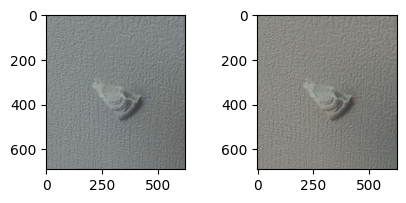

In [ ]:
import matplotlib.gridspec as gridspec
num = 2223
plt.figure(figsize=(5,2))
sample = train.img_path[num]
image = cv2.imread(sample)
image1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
grid = gridspec.GridSpec(1,2)
ax = plt.subplot(grid[0])
ax.imshow(image)
ax = plt.subplot(grid[1])
ax.imshow(image1)

In [ ]:
image.shape

(691, 625, 3)

## Target Encoding
 - Classification 문제이기 때문에, Target의 Class를 파악합니다.
 - Class를 0, 1, 2, 3, ... 으로 인코딩을 합니다.

In [ ]:
le = LabelEncoder()

In [ ]:
train['new_target'] = le.fit_transform(train['label'])

In [ ]:
train.head()

,img_path,label,new_target
0,/content/drive/MyDrive/Colab Notebooks/ai6th/d...,가구수정,0
1,/content/drive/MyDrive/Colab Notebooks/ai6th/d...,가구수정,0
2,/content/drive/MyDrive/Colab Notebooks/ai6th/d...,가구수정,0
3,/content/drive/MyDrive/Colab Notebooks/ai6th/d...,가구수정,0
4,/content/drive/MyDrive/Colab Notebooks/ai6th/d...,가구수정,0


In [ ]:
train.label.value_counts()

훼손                 1405
오염                  595
걸레받이수정        307
꼬임                  210
터짐                  162
곰팡이               145
오타공                142
몰딩수정            130
면불량               99
석고수정              57
들뜸                  54
피스                    51
창틀,문틀수정      27
울음                  22
이음부불량           17
녹오염                14
가구수정               12
틈새과다                5
반점                   3
Name: label, dtype: int64

In [ ]:
train.new_target.value_counts()

18    1405
10     595
1      307
3      210
15     162
2      145
11     142
7      130
6       99
9       57
5       54
17      51
14      27
12      22
13      17
4       14
0       12
16       5
8        3
Name: new_target, dtype: int64

In [ ]:
n_classes = train.new_target.nunique()
n_classes

19

## Set Seed

 > 실험적인 시도 혹은 Model Ensemble할 때 유용합니다.

In [ ]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)


In [ ]:
## Set Seed
set_seed(config['seed'])

## Augmentation

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(config['img_size'], config['img_size']),
        A.RandomCrop(config['img_size'], config['img_size']),
        # A.Rotate(limit=45, p=1, border_mode=cv2.BORDER_REPLICATE),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        ToTensorV2()
    ]
)


valid_transform = A.Compose(
    [
        A.Resize(config['img_size'], config['img_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        ToTensorV2()
    ]
)


test_transform = A.Compose(
    [
        A.Resize(config['img_size'], config['img_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        ToTensorV2()
    ]
)

### Dataset -> DataLoader

In [ ]:
class MyDataset(Dataset):
    def __init__(self, df, transforms=None, mode = "train"):
        self.mode = mode
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.df['img_path'][index]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        if self.mode == "train":
            label = self.df.new_target[index]
            return torch.tensor(image, dtype = torch.float16), torch.tensor(label, dtype = torch.long)
        else:
            return torch.tensor(image, dtype = torch.float16)

In [ ]:
def prepare_loaders(
    train,
    ratio = .7,
    train_bs = config['train_batch_size'],
    valid_bs = config['valid_batch_size'],
    train_transform = train_transform,
    valid_transform = valid_transform
):
    index_num = int(ratio * train.shape[0])
    train_df = train[:index_num].reset_index(drop=True)
    valid_df = train[index_num:].reset_index(drop=True)

    ## train, valid -> Dataset
    train_ds = MyDataset(df = train_df, transforms = train_transform, mode = "train")
    valid_ds = MyDataset(df = valid_df, transforms = valid_transform, mode = "train")

    # train_loader, valid_loader
    train_loader = DataLoader(train_ds, batch_size = train_bs, shuffle = True)
    valid_loader = DataLoader(valid_ds, batch_size = valid_bs, shuffle = False)

    print("DataLoader is Completed")
    return train_loader, valid_loader

In [ ]:
train_loader, valid_loader = prepare_loaders(
    train = train,
    ratio = config['ratio'],
    train_bs = config['train_batch_size'],
    valid_bs = config['valid_batch_size'],
    train_transform = train_transform,
    valid_transform = valid_transform
)

DataLoader is Completed


In [ ]:
# data = next(iter(train_loader))
# data[0].shape, data[1].shape
# # [bs, 3, img_size, img_size]    [bs]

## EfficientModel

In [ ]:
print(config['model'])
model = timm.create_model(config['model'], pretrained=True, num_classes=n_classes).to(config['device'])

efficientnet_b4


In [ ]:
summary(model)

Layer (type:depth-idx)                        Param #
EfficientNet                                  --
├─Conv2d: 1-1                                 1,296
├─BatchNormAct2d: 1-2                         96
│    └─Identity: 2-1                          --
│    └─SiLU: 2-2                              --
├─Sequential: 1-3                             --
│    └─Sequential: 2-3                        --
│    │    └─DepthwiseSeparableConv: 3-1       2,940
│    │    └─DepthwiseSeparableConv: 3-2       1,206
│    └─Sequential: 2-4                        --
│    │    └─InvertedResidual: 3-3             11,878
│    │    └─InvertedResidual: 3-4             18,120
│    │    └─InvertedResidual: 3-5             18,120
│    │    └─InvertedResidual: 3-6             18,120
│    └─Sequential: 2-5                        --
│    │    └─InvertedResidual: 3-7             25,848
│    │    └─InvertedResidual: 3-8             57,246
│    │    └─InvertedResidual: 3-9             57,246
│    │    └─InvertedResidua

# Train

## Loss_function, Optimizer, Scheduler

### Loss Function

In [ ]:
loss_fn = nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

### Optimizer

In [ ]:
# optimizer
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=config['learning_rate'])
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)

### Scheduler

In [ ]:
# Scheduler
from torch.optim import lr_scheduler

scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer,
                                                     T_0=20,
                                                     T_mult=1,
                                                     eta_min=config['min_lr'])
scheduler

## train_one_epoch()

In [ ]:
def train_one_epoch(model, dataloader, loss_fn, optimizer, device, epoch, n_classes, scheduler = None):

    ################ torchmetrics: initialize metric #########################

    metric_f1 = torchmetrics.F1Score(task='multiclass', average = 'weighted', num_classes=n_classes).to(device)

    ############################################################################

    train_loss = 0
    dataset_size = 0

    bar = tqdm(enumerate(dataloader), total = len(dataloader), desc='Train Loop')

    model.train()
    for step, data in bar:
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            # imgs
            imgs = data[0].to(device)

            # targets
            targets = data[1].to(device)

            # y_preds
            y_preds = model(imgs)
            y_preds = torch.softmax(y_preds, dim=-1)

            # Loss
            loss = loss_fn(y_preds, targets)

        # Back-Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        # Loss
        # train_epoch_loss: 실시간 누적되는 Batch들의 loss 값
        batch_size = imgs.size(0)
        dataset_size += batch_size
        train_loss += float(loss.item() * batch_size)
        train_epoch_loss = train_loss / dataset_size

        # F1 Score: Batch 단위
        f1 = metric_f1(y_preds, targets)
        f1 = f1.detach().cpu().item()

        bar.set_postfix(Epoch = epoch,
                        Train_loss = train_epoch_loss,
                        LR = optimizer.param_groups[0]['lr'],
                        F1_SCORE = f1,
                        )

    train_f1 = metric_f1.compute().cpu().item()

    print("Train's F1_Score(Weighted): %.2f" % (train_f1))
    print()

    # Reseting internal state such that metric ready for new data
    metric_f1.reset()

    torch.cuda.empty_cache()
    _ = gc.collect()

    return train_epoch_loss, train_f1

## valid_one_epoch()

In [ ]:
# Valid One Epoch
@torch.no_grad()
def valid_one_epoch(model, dataloader, loss_fn, optimizer, device, epoch, n_classes):

    ################ torchmetrics: initialize metric #########################

    metric_f1 = torchmetrics.F1Score(task='multiclass', average = 'weighted', num_classes=n_classes).to(device)

    ############################################################################

    valid_loss = 0
    dataset_size = 0

    #tqdm의 경우, for문에서 iterate할 때 실시간으로 보여주는 라이브러리입니다. 보시면 압니다.
    bar = tqdm(enumerate(dataloader), total = len(dataloader), desc='Valid Loop')

    model.eval()
    with torch.no_grad():
        for step, data in bar:
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                # imgs
                imgs = data[0].to(device)

                # targets
                targets = data[1].to(device)

                # y_preds
                y_preds = model(imgs)
                y_preds = torch.softmax(y_preds, dim=-1)

                # Loss
                loss = loss_fn(y_preds, targets)

            # 실시간 Loss
            batch_size = imgs.size(0)
            dataset_size += batch_size
            valid_loss += float(loss.item() * batch_size)
            valid_epoch_loss = valid_loss / dataset_size

            # F1 Score: Batch 단위
            f1 = metric_f1(y_preds, targets)
            f1 = f1.detach().cpu().item()

            bar.set_postfix(Epoch = epoch,
                            Valid_loss = valid_epoch_loss,
                            LR = optimizer.param_groups[0]['lr'],
                            F1_SCORE = f1,
                            )


    # Type - ACC
    valid_f1 = metric_f1.compute().cpu().item()

    print("Valid's F1_Score(Weighted): %.2f" % (valid_f1))
    print()

    # Reseting internal state such that metric ready for new data
    metric_f1.reset()

    torch.cuda.empty_cache()
    _ = gc.collect()

    return valid_epoch_loss, valid_f1

## run_train()

In [ ]:
# Run Train
def run_train(model,
              model_save,
              train_loader,
              valid_loader,
              loss_fn,
              optimizer,
              device,
              n_classes,
              scheduler,
              n_epochs
              ):

    if torch.cuda.is_available():
        print("INFO: GPU - {}\n".format(torch.cuda.get_device_name()))

    start = time.time()

    lowest_epoch, lowest_loss, best_score_epoch = np.inf, np.inf, np.inf
    train_hs, valid_hs, train_f1s, valid_f1s = [], [], [], [],
    best_score = 0

    for epoch in range(n_epochs):

        train_epoch_loss, train_f1 = train_one_epoch(model, train_loader, loss_fn, optimizer, device, epoch, n_classes, scheduler)
        valid_epoch_loss, valid_f1 = valid_one_epoch(model, valid_loader, loss_fn, optimizer, device, epoch, n_classes)

        ## 줍줍
        train_hs.append(train_epoch_loss)
        valid_hs.append(valid_epoch_loss)

        train_f1s.append(train_f1)
        valid_f1s.append(valid_f1)

        print()
        print(f"Epoch:{epoch+1:02d} | TL:{train_epoch_loss:.3e} | VL:{valid_epoch_loss:.3e} | Train's F1: {train_f1:.2f} | Valid's F1: {valid_f1:.2f} |")
        print()

        if valid_epoch_loss < lowest_loss:
            print(f"Validation Loss Improved({lowest_loss:.3e}) --> ({valid_epoch_loss:.3e})")
            lowest_loss = valid_epoch_loss
            lowest_epoch = epoch
            PATH = model_save + f"model_loss.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Better Loss Model Saved")

        if best_score < valid_f1:
            print(f"F1_SCORE Improved({best_score:.3f}) --> ({valid_f1:.3f})")
            best_score = valid_f1
            best_score_epoch = epoch
            PATH2 = model_save + f"model_f1.bin"
            torch.save(model.state_dict(), PATH2)
            print(f"Better_F1_SCORE_Model Saved")
        print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss : %.4e at %d th Epoch" % (lowest_loss, lowest_epoch))
    print("Best F1_SCORE: %.4f at %d th Epoch" % (best_score, best_score_epoch))

    result = dict()
    result["Train Loss"] = train_hs
    result["Valid Loss"] = valid_hs

    result["Train F1_SCORE"] = train_f1s
    result["Valid F1_SCORE"] = valid_f1s

    torch.cuda.empty_cache()
    _ = gc.collect()

    return result

## Let's Train!

In [ ]:
result = run_train(model = model,
                   model_save = config['model_save'],
                   train_loader = train_loader,
                   valid_loader = valid_loader,
                   loss_fn = loss_fn,
                   optimizer = optimizer,
                   device = config['device'],
                   n_classes = n_classes,
                   scheduler = scheduler,
                   n_epochs= config['n_epochs'])

INFO: GPU - Tesla T4



Train Loop:   0%|          | 0/38 [00:00<?, ?it/s]

Train's F1_Score(Weighted): 0.27



Valid Loop:   0%|          | 0/17 [00:00<?, ?it/s]

Valid's F1_Score(Weighted): 0.01


Epoch:01 | TL:2.665e+00 | VL:3.011e+00 | Train's F1: 0.27 | Valid's F1: 0.01 |

Validation Loss Improved(inf) --> (3.011e+00)
Better Loss Model Saved
F1_SCORE Improved(0.000) --> (0.013)
Better_F1_SCORE_Model Saved



Train Loop:   0%|          | 0/38 [00:00<?, ?it/s]

Train's F1_Score(Weighted): 0.51



Valid Loop:   0%|          | 0/17 [00:00<?, ?it/s]

Valid's F1_Score(Weighted): 0.70


Epoch:02 | TL:2.458e+00 | VL:2.493e+00 | Train's F1: 0.51 | Valid's F1: 0.70 |

Validation Loss Improved(3.011e+00) --> (2.493e+00)
Better Loss Model Saved
F1_SCORE Improved(0.013) --> (0.703)
Better_F1_SCORE_Model Saved



Train Loop:   0%|          | 0/38 [00:00<?, ?it/s]

Train's F1_Score(Weighted): 0.69



Valid Loop:   0%|          | 0/17 [00:00<?, ?it/s]

Valid's F1_Score(Weighted): 0.85


Epoch:03 | TL:2.303e+00 | VL:2.302e+00 | Train's F1: 0.69 | Valid's F1: 0.85 |

Validation Loss Improved(2.493e+00) --> (2.302e+00)
Better Loss Model Saved
F1_SCORE Improved(0.703) --> (0.846)
Better_F1_SCORE_Model Saved



Train Loop:   0%|          | 0/38 [00:00<?, ?it/s]

Train's F1_Score(Weighted): 0.75



Valid Loop:   0%|          | 0/17 [00:00<?, ?it/s]

Valid's F1_Score(Weighted): 0.79


Epoch:04 | TL:2.241e+00 | VL:2.381e+00 | Train's F1: 0.75 | Valid's F1: 0.79 |




Train Loop:   0%|          | 0/38 [00:00<?, ?it/s]

Train's F1_Score(Weighted): 0.78



Valid Loop:   0%|          | 0/17 [00:00<?, ?it/s]

Valid's F1_Score(Weighted): 0.87


Epoch:05 | TL:2.212e+00 | VL:2.263e+00 | Train's F1: 0.78 | Valid's F1: 0.87 |

Validation Loss Improved(2.302e+00) --> (2.263e+00)
Better Loss Model Saved
F1_SCORE Improved(0.846) --> (0.870)
Better_F1_SCORE_Model Saved

Training complete in 0h 31m 42s
Best Loss : 2.2631e+00 at 4 th Epoch
Best F1_SCORE: 0.8699 at 4 th Epoch


# Visualization

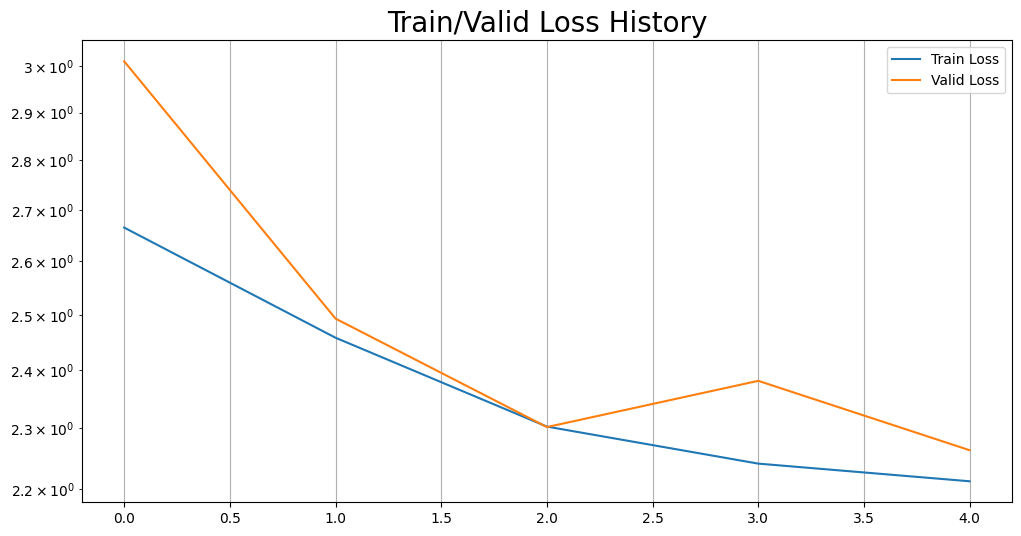

In [ ]:
## Train/Valid History
plot_from = 0
plt.figure(figsize=(12, 6))
plt.title("Train/Valid Loss History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Loss'][plot_from:])),
    result['Train Loss'][plot_from:],
    label = 'Train Loss'
    )

plt.plot(
    range(0, len(result['Valid Loss'][plot_from:])),
    result['Valid Loss'][plot_from:],
    label = 'Valid Loss'
    )

plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

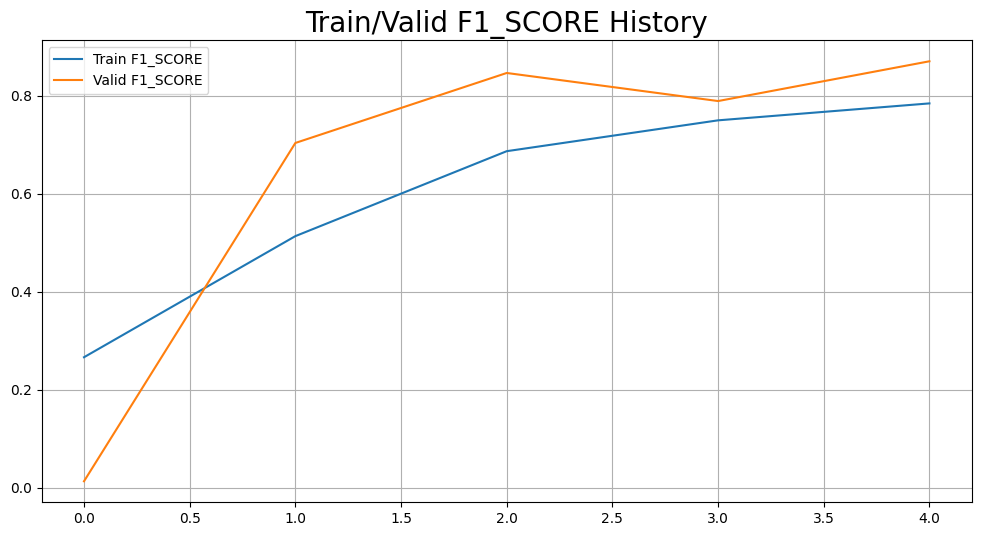

In [ ]:
# Train/Valid Accuracy
plot_from = 0
plt.figure(figsize=(12, 6))
plt.title("Train/Valid F1_SCORE History", fontsize = 20)
plt.plot(
    range(0, len(result['Train F1_SCORE'])),
    result['Train F1_SCORE'],
    label = 'Train F1_SCORE'
    )

plt.plot(
    range(0, len(result['Valid F1_SCORE'])),
    result['Valid F1_SCORE'],
    label = 'Valid F1_SCORE'
    )

plt.legend()
# plt.yscale('log')
plt.grid(True)
plt.show()

# inference

In [ ]:
config['data_path']

'/content/drive/MyDrive/Colab Notebooks/ai6th/data/decorate/'

In [ ]:
test = pd.read_csv(config['data_path'] + 'test.csv')
test['img_path'] = test['img_path'].apply(lambda x: config['data_path'] + str(x)[1:])
print(test.shape)
test.head()

(792, 2)


,id,img_path
0,TEST_000,/content/drive/MyDrive/Colab Notebooks/ai6th/d...
1,TEST_001,/content/drive/MyDrive/Colab Notebooks/ai6th/d...
2,TEST_002,/content/drive/MyDrive/Colab Notebooks/ai6th/d...
3,TEST_003,/content/drive/MyDrive/Colab Notebooks/ai6th/d...
4,TEST_004,/content/drive/MyDrive/Colab Notebooks/ai6th/d...


## Sample

Sample Image


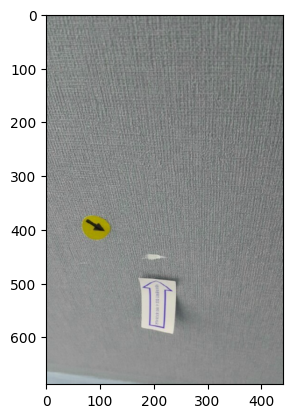

In [ ]:
num = 222
sample = test.img_path[num]
image = cv2.imread(sample)
print("Sample Image")
plt.imshow(image)

In [ ]:
image.shape

(688, 441, 3)

## Test Loader

In [ ]:
def prepare_testloader(test = test,
                       test_transform = test_transform,
                       bs = config['valid_batch_size']):

    test_ds = MyDataset(df = test, transforms = test_transform, mode = "test")
    test_loader = DataLoader(test_ds, batch_size = bs, shuffle = False)

    print("TestLoader Completed")
    return test_loader

In [ ]:
test_loader = prepare_testloader(test = test,
                                test_transform = test_transform,
                                bs = config['valid_batch_size'])

TestLoader Completed


## Test Function

In [ ]:
@torch.no_grad()
def test_func(model, dataloader, device):

    preds = []

    model.eval()
    with torch.no_grad():
        bar = tqdm(enumerate(dataloader), total = len(dataloader))
        for step, data in bar:
            imgs = data.to(device)

            y_preds = model(imgs)
            y_preds = torch.softmax(y_preds, dim=-1)
            preds.append(y_preds.detach().cpu().numpy())

    predictions = np.concatenate(preds, axis= 0)
    gc.collect()

    return predictions

## Trained Model Saved Path List

In [ ]:
%pwd

'/content'

In [ ]:
%ls

drive/  model_f1.bin  model_loss.bin  sample_data/


In [ ]:
# Model paths
def trained_model_paths(model_type = "Loss", model_save = config['model_save']):

    model_path = []

    if model_type == "Loss":
        model_path.append(model_save + f"model_loss.bin")
    else:
        model_path.append(model_save + f"model_f1.bin")

    print(model_path)
    return model_path

In [ ]:
model_path = trained_model_paths(model_type = "F1", model_save = config['model_save'])

['/content/model_f1.bin']


## Inference Function

In [ ]:
def inference(model_path, model_name, dataloader, device):


    print(config['model'])
    model = timm.create_model(config['model'], pretrained=True, num_classes=n_classes).to(device)
    model.load_state_dict(torch.load(model_path[0]))
    print("Model Loaded")

    print(f"Getting predictions for model")
    preds = test_func(model, dataloader, device)

    print(f"Shape of `preds`: {preds.shape}")
    return preds

## Inference GoGo

In [ ]:
## GoGo
from  torch.cuda.amp import autocast
with autocast():
    final_preds = inference(model_path = model_path,
                        model_name = config['model'],
                        dataloader = test_loader,
                        device = config['device'])

efficientnet_b4
Model Loaded
Getting predictions for model


  0%|          | 0/13 [00:00<?, ?it/s]

Shape of `preds`: (792, 19)


In [ ]:
print(final_preds.shape) # [BS, 4] # 4: n_classes
final_preds

(792, 19)


array([[1.5459220e-08, 1.9095285e-06, 1.8494740e-05, ..., 2.6092373e-08,
        5.1502434e-06, 9.9931490e-01],
       [5.8128828e-11, 4.6982310e-11, 3.7514516e-09, ..., 2.5949967e-10,
        1.8837658e-10, 5.0723578e-08],
       [5.2661502e-08, 4.8630671e-05, 2.3480881e-02, ..., 5.0552802e-07,
        2.9652030e-04, 8.9498913e-01],
       ...,
       [9.1573570e-15, 2.0469716e-16, 3.5157109e-12, ..., 3.1400701e-15,
        1.5886793e-13, 5.8840381e-08],
       [7.4687814e-05, 9.4414238e-05, 1.1081344e-04, ..., 5.1525344e-06,
        1.5265196e-04, 9.3890671e-03],
       [4.8801131e-04, 3.6580608e-05, 4.0333183e-05, ..., 5.2905621e-06,
        4.5221907e-04, 9.3833470e-01]], dtype=float32)

In [ ]:
# argmax로 가장 확률이 높은 Class의 index를 반환해줍니다.
new_preds = np.argmax(final_preds , axis = 1)
new_preds.shape

(792,)

In [ ]:
## Submission File
ss = pd.read_csv(config['data_path'] + 'sample_submission.csv')
print(ss.shape)
ss.head()

(792, 2)


,id,label
0,TEST_000,훼손
1,TEST_001,훼손
2,TEST_002,훼손
3,TEST_003,훼손
4,TEST_004,훼손


In [ ]:
ss['label'] = new_preds
ss.head()

,id,label
0,TEST_000,18
1,TEST_001,10
2,TEST_002,18
3,TEST_003,7
4,TEST_004,10


In [ ]:
ss.label.value_counts()

10    300
18    292
15     42
6      35
3      26
7      20
2      20
11     19
17     17
1      14
5       6
4       1
Name: label, dtype: int64

## Back to Original Value

In [ ]:
## Encoded Target을 원래대로 돌립니다.
#ss['label'] = le.inverse_transform(new_preds)

labelToName = {
    0:'가구수정',
    1:'걸레받이수정',
    2:'곰팡이',
    3:'꼬임',
    4:'녹오염',
    5:'들뜸',
    6:'면불량',
    7:'몰딩수정',
    8:'반점',
    9:'석고수정',
    10:'오염',
    11:'오타공',
    12:'울음',
    13:'이음부불량',
    14:'창틀,문틀수정',
    15:'터짐',
    16:'틈새과다',
    17:'피스',
    18:'훼손'
}

ss['label'] = ss['label'].map(labelToName)

In [ ]:
## 확인
print(ss.shape)
ss.head()

(792, 2)


,id,label
0,TEST_000,훼손
1,TEST_001,오염
2,TEST_002,훼손
3,TEST_003,몰딩수정
4,TEST_004,오염


In [ ]:
ss.label.value_counts() ## 예의상 확인

오염        300
훼손        292
터짐         42
면불량        35
꼬임         26
몰딩수정       20
곰팡이        20
오타공        19
피스         17
걸레받이수정     14
들뜸          6
녹오염         1
Name: label, dtype: int64

## Submission CSV file Save

In [ ]:
config['data_path'], config['sub_path']

('/content/drive/MyDrive/Colab Notebooks/ai6th/data/decorate/', '/content/')

In [ ]:
sub_file_name = config['sub_path'] + config['model']  + "_epochs_" + str(config["n_epochs"]) + "_LR" + str(config["learning_rate"]) + ".csv"
sub_file_name

'/content/efficientnet_b4_epochs_5_LR0.001.csv'

In [ ]:
ss.to_csv(sub_file_name, index=False, encoding='utf-8')
print("submission file saved")

submission file saved


In [ ]:
ss.to_csv('./submission.csv', index=False, encoding='utf-8')